In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f

import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



transform  = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])



For the Code in Tensorflow/Keras, please refer: https://www.kaggle.com/code/priyankdl/cifar10-with-transferlearning-flow-from-directory

The following code is written in PyTorch. If you like the notebook, please upvote it.

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True, transform=transform)




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:

classes = train_dataset.classes
print(classes)


#classnames to classids
name2num={}
i=0
for name in classes:
    name2num[name]=i
    i=i+1

num2name={}
for i in range(len(classes)):
    num2name[i]=classes[i]

print(num2name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize, Resize, Compose

# class TrainDataset(Dataset):
#     def __init__(self, imgpath, labelpath):
#         super().__init__()
#         self.imgpath=imgpath
#         self.labelpath=labelpath
#         self.labels=pd.read_csv(labelpath, header='infer')
#         self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

#     def __len__(self):
#         return self.labels.shape[0]

#     def __getitem__(self,idx):
#         finalpath=os.path.join(self.imgpath,str(idx+1))+'.png'
#         img=read_image(finalpath)/255
#         img=self.transform(img)
#         label=self.labels.iloc[idx,1]
#         label=name2num[label]
#         return img,label

# batch_size=64
# traindataloader=DataLoader(dataset=train_dataset , batch_size=batch_size)



In [ ]:
import torch.utils
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

In [ ]:
data_iter = iter(train_loader)
images ,labels = data_iter.__next__()
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 28, 28])
torch.Size([64])


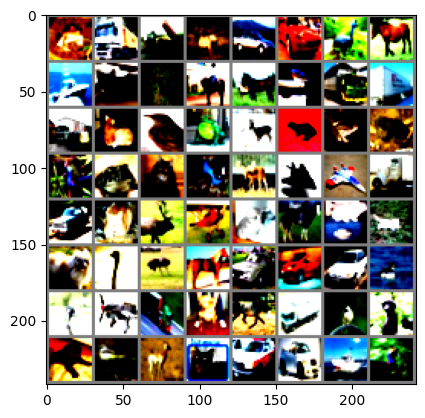

In [ ]:


def imshow(img):
  img = img/0.5+0.5
  npimg  = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
class Cifar10Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        self.pretrainednet.classifier=nn.Sequential(
            nn.Linear(in_features=960, out_features=1280,
                   bias=True),nn.Hardswish(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=10,
                      bias=True)
        )

    def forward(self,x):
        x=self.pretrainednet(x)
        return x

In [ ]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0
    num_param=0

    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)

        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

In [ ]:
# !pip install --upgrade torch torchvision


In [ ]:
model=Cifar10Net()
model=model.to(device)

for param in model.pretrainednet.features.parameters():
    param.requires_grad=False

loss_fn=nn.CrossEntropyLoss()
lr=0.001
# optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=5

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_loader,model,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

for param in model.pretrainednet.features.parameters():
    param.requires_grad=True

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_loader,model,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

Epoch No: 1
Batch: 1 / 782 Running Loss: 2.34 Running Accuracy: 9.38
Batch: 101 / 782 Running Loss: 2.01 Running Accuracy: 28.37
Batch: 201 / 782 Running Loss: 1.94 Running Accuracy: 30.84
Batch: 301 / 782 Running Loss: 1.92 Running Accuracy: 31.62
Batch: 401 / 782 Running Loss: 1.9 Running Accuracy: 32.17
Batch: 501 / 782 Running Loss: 1.89 Running Accuracy: 32.68
Batch: 601 / 782 Running Loss: 1.88 Running Accuracy: 33.09
Batch: 701 / 782 Running Loss: 1.87 Running Accuracy: 33.2
Training: Epoch Loss: 1.87 Epoch Accuracy: 33.47
--------------------------------------------------
Epoch No: 2
Batch: 1 / 782 Running Loss: 1.77 Running Accuracy: 34.38
Batch: 101 / 782 Running Loss: 1.71 Running Accuracy: 39.42
Batch: 201 / 782 Running Loss: 1.68 Running Accuracy: 40.82
Batch: 301 / 782 Running Loss: 1.66 Running Accuracy: 41.33
Batch: 401 / 782 Running Loss: 1.65 Running Accuracy: 41.83
Batch: 501 / 782 Running Loss: 1.63 Running Accuracy: 42.61
Batch: 601 / 782 Running Loss: 1.62 Running

In [ ]:
class TestDataset(Dataset):
    def __init__(self, imgpath):
        super().__init__()
        self.imgpath=imgpath
        _,_,self.files=next(os.walk(self.imgpath))
        self.length=len(self.files)
        self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        finalpath=os.path.join(self.imgpath,str(idx+1))+'.png'
        img=read_image(finalpath)/255.0
        img=self.transform(img)
        return img

testdataloader=DataLoader(dataset=test_dataset, batch_size=batch_size)

In [ ]:
def eval(dataloader, model,loss_fn, path):
    model.eval()
    data=pd.read_csv(path)
    with torch.no_grad():
        for i, imgs in enumerate(dataloader):
            finalbatchpred=np.zeros(imgs.shape[0],dtype='object')
            imgs=imgs.to(device)
            pred=model(imgs)

            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            for j,p in enumerate(pred):
                finalbatchpred[j]=num2name[p.item()]
            data.iloc[i*batch_size:i*batch_size+batch_size ,1]=finalbatchpred


    data.to_csv('submission.csv', index=False)
    data.head()

In [ ]:
eval(testdataloader, model,loss_fn, 'submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'

If you liked the notebook, please upvote it.